In [1]:
pip install qiskit_nature


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pyscf


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms.optimizers import SLSQP

qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2

import numpy as np

from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

#### Obtaining the Ground State Energy of Water (H2O)

In [62]:
def get_qubit_op(dist1, dist2):
    # dist = list of 5 distance variables instead of being only 1 variable
    
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["O", "H", "H"],
        #coords=([0.0, 0.0, dist[0]], [0.0, dist[1], dist[2]], [0.0, dist[3], dist[4]]),
        #coords=([0.0, 0.0, dist], [0.0, dist, dist], [0.0, dist, dist]),
        coords=([0.0, 0.0, dist1], [0.0, dist2, -0.47116], [0.0, -0.75545, -0.47116]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    #print(molecule, '\n')
    
    driver = PySCFDriver.from_molecule(molecule)
    
    
    properties = driver.run()
    

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [64]:
a = get_qubit_op(0.5, 0.7)

In [65]:
from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.3, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    #dist_list = [distance, distance, distance, distance, distance]
    
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist, dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Interatomic Distance: 0.3 VQE Result: -74.90806 Exact Energy: -74.90832


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (19,) and (2,)

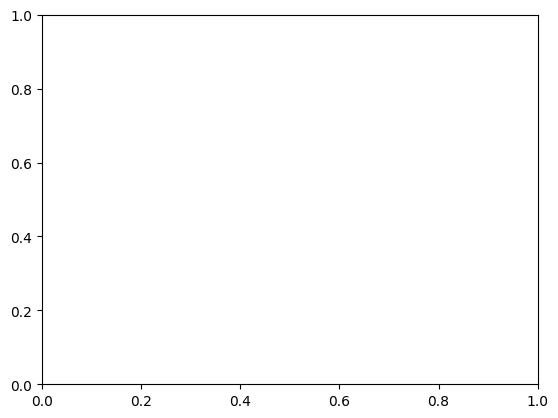

In [61]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, 'o', label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()


---


In [66]:
def get_qubit_op(dist):
    # dist = list of 5 distance variables instead of being only 1 variable
        
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["O", "H", "H"],

        coords=([0.0, 0.0, dist[0]], [0.0, dist[1], -0.47116], [0.0, -0.75545, -0.47116]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    #print(molecule, '\n')
    
    driver = PySCFDriver.from_molecule(molecule)
    
    
    properties = driver.run()
    

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [78]:
from qiskit_aer.primitives import Estimator

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

distances = np.arange(0.9, 1.8, 0.3)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
noiseless_estimator = Estimator(approximation=True)

In [79]:
for dist1 in distances:
    for dist2 in distances:
        (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op([dist1, dist2])

        result = exact_solver(qubit_op, problem)
        exact_energies.append(result.total_energies[0].real)
        init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
        var_form = UCCSD(
            num_spatial_orbitals, num_particles, mapper, initial_state=init_state
        )
        vqe = VQE(
            noiseless_estimator,
            var_form,
            optimizer,
            initial_point=[0] * var_form.num_parameters,
        )
        vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
        vqe_result = problem.interpret(vqe_calc).total_energies[0].real
        vqe_energies.append(vqe_result)
        print(
            f"Interatomic Distance: {np.round(dist, 2)}",
            f"VQE Result: {vqe_result:.5f}",
            f"Exact Energy: {exact_energies[-1]:.5f}",
        )

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -74.80822 Exact Energy: -74.82576
Interatomic Distance: 0.5 VQE Result: -74.79729 Exact Energy: -74.81345
Interatomic Distance: 0.5 VQE Result: -74.78765 Exact Energy: -74.80157
Interatomic Distance: 0.5 VQE Result: -74.71015 Exact Energy: -74.77053
Interatomic Distance: 0.5 VQE Result: -74.69043 Exact Energy: -74.76110
Interatomic Distance: 0.5 VQE Result: -74.67920 Exact Energy: -74.76079
Interatomic Distance: 0.5 VQE Result: -74.68039 Exact Energy: -74.77481
Interatomic Distance: 0.5 VQE Result: -74.65290 Exact Energy: -74.75229
Interatomic Distance: 0.5 VQE Result: -74.64139 Exact Energy: -74.74506
All energies have been calculated


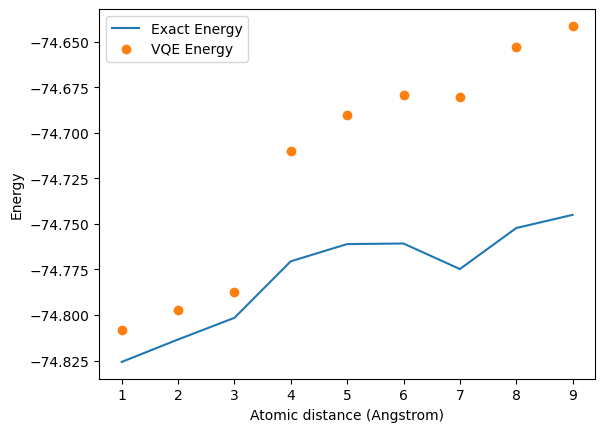

In [86]:
plt.plot([i for i in range(1,10)], exact_energies, label="Exact Energy")
plt.plot([i for i in range(1,10)], vqe_energies, 'o', label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()